In [65]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
batch_size = 32
img_height = 100
img_width = 100

In [53]:
import os
downloaded_data = tf.keras.utils.get_file(
      'chess.tgz',
      'https://github.com/DenverCoder1/chess-piece-classifier/blob/main/data/chess.tgz?raw=true',
      extract=True)
image_path = os.path.join(os.path.dirname(downloaded_data), 'chess')
print(image_path)
train_ds = tf.keras.utils.image_dataset_from_directory(image_path, subset='training', seed=123, image_size=(img_width, img_height), batch_size=batch_size, validation_split=0.2)
val_ds = tf.keras.utils.image_dataset_from_directory(image_path, subset='validation', seed=123, image_size=(img_width, img_height), batch_size=batch_size, validation_split=0.2)

/root/.keras/datasets/chess
Found 393 files belonging to 6 classes.
Using 315 files for training.
Found 393 files belonging to 6 classes.
Using 78 files for validation.


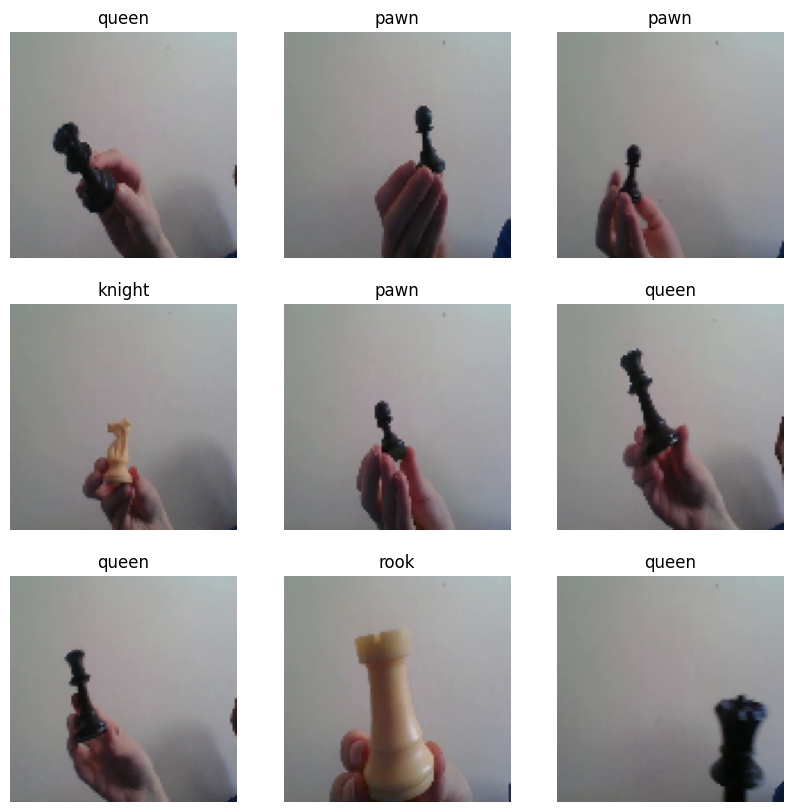

In [54]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(10,10))
for imgs, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+ 1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [55]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [126]:
num_classes = len(class_names)

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)
base = tf.keras.models.load_model('model.keras')

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  # First Convolutional Block
  layers.Conv2D(16, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Second Convolutional Block
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Third Convolutional Block
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #Dropout
  # layers.Dropout(0.2),
  # Classifier Head
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dense(units=num_classes, activation="sigmoid"),
  # layers.Flatten(),
  # layers.Dense(128, activation='relu'),
  # layers.Dense(num_classes)
])


In [127]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [128]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_24 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_74 (Conv2D)          (None, 100, 100, 16)      1216      
                                                                 
 max_pooling2d_74 (MaxPooli  (None, 50, 50, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_75 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 25, 25, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 25, 25, 64)      

In [130]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  # callbacks=[early_stopping]
)

Epoch 1/100
10/10 [==============================] - 2s 238ms/step - loss: 1.7902 - accuracy: 0.1873 - val_loss: 1.7961 - val_accuracy: 0.1282
Epoch 2/100
10/10 [==============================] - 2s 234ms/step - loss: 1.7900 - accuracy: 0.1873 - val_loss: 1.7964 - val_accuracy: 0.1282
Epoch 3/100
10/10 [==============================] - 2s 235ms/step - loss: 1.7899 - accuracy: 0.1873 - val_loss: 1.7968 - val_accuracy: 0.1282
Epoch 4/100
10/10 [==============================] - 3s 256ms/step - loss: 1.7898 - accuracy: 0.1873 - val_loss: 1.7973 - val_accuracy: 0.1282
Epoch 5/100
10/10 [==============================] - 3s 274ms/step - loss: 1.7897 - accuracy: 0.1873 - val_loss: 1.7977 - val_accuracy: 0.1282
Epoch 6/100
10/10 [==============================] - 2s 237ms/step - loss: 1.7895 - accuracy: 0.1873 - val_loss: 1.7980 - val_accuracy: 0.1282
Epoch 7/100
10/10 [==============================] - 2s 240ms/step - loss: 1.7894 - accuracy: 0.1873 - val_loss: 1.7983 - val_accuracy: 0.1282

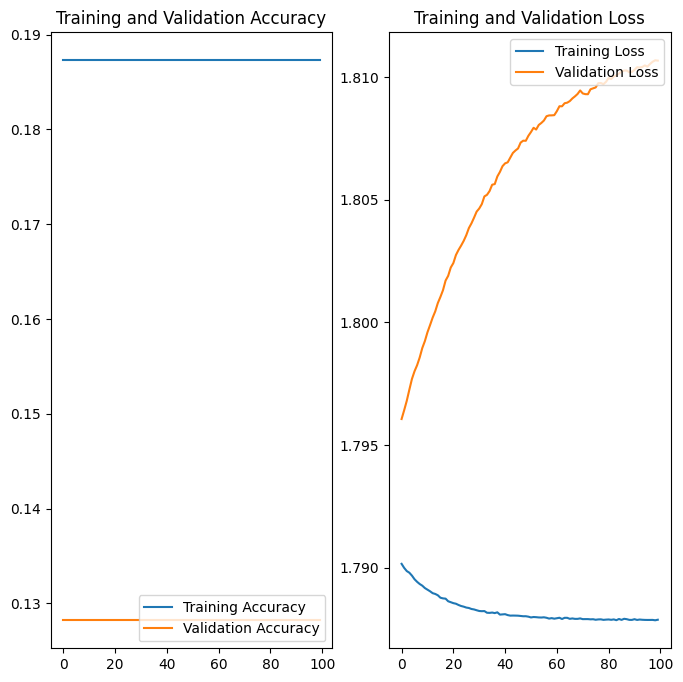

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [135]:

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


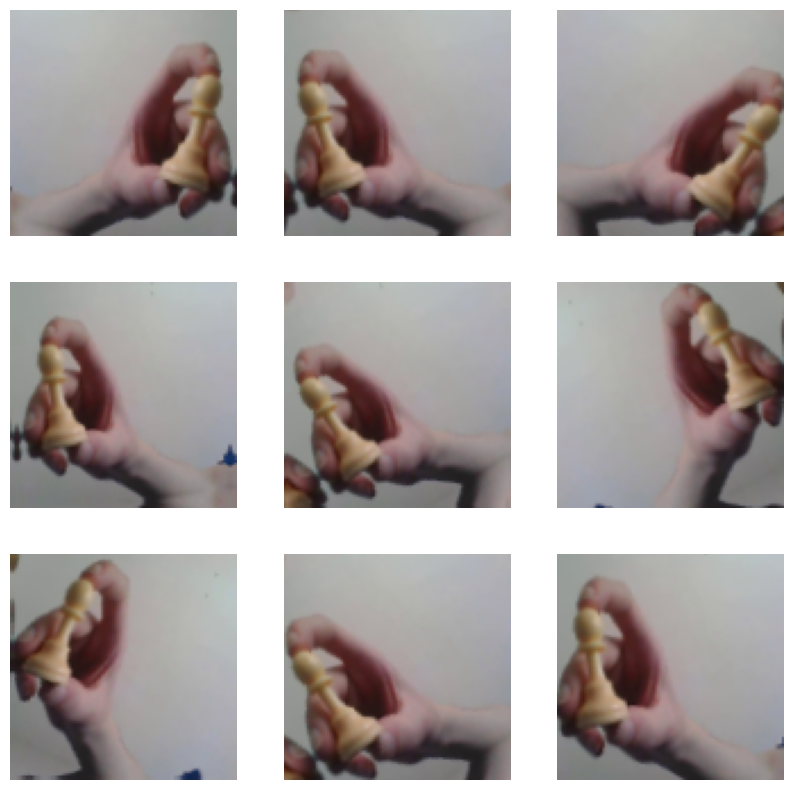

In [136]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [137]:

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [138]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [139]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25 (Sequential)  (None, 100, 100, 3)       0         
                                                                 
 rescaling_25 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_78 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_78 (MaxPooli  (None, 50, 50, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_79 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_79 (MaxPooli  (None, 25, 25, 32)        0         
 ng2D)                                               

In [140]:

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
10/10 [==============================] - 4s 223ms/step - loss: 1.8440 - accuracy: 0.1619 - val_loss: 1.7968 - val_accuracy: 0.1282
Epoch 2/15
10/10 [==============================] - 2s 201ms/step - loss: 1.7920 - accuracy: 0.1873 - val_loss: 1.7941 - val_accuracy: 0.1282
Epoch 3/15
10/10 [==============================] - 2s 200ms/step - loss: 1.7902 - accuracy: 0.1873 - val_loss: 1.7987 - val_accuracy: 0.1282
Epoch 4/15
10/10 [==============================] - 2s 236ms/step - loss: 1.7909 - accuracy: 0.1873 - val_loss: 1.8055 - val_accuracy: 0.1282
Epoch 5/15
10/10 [==============================] - 3s 260ms/step - loss: 1.7897 - accuracy: 0.1873 - val_loss: 1.7970 - val_accuracy: 0.1282
Epoch 6/15
10/10 [==============================] - 2s 197ms/step - loss: 1.7876 - accuracy: 0.1873 - val_loss: 1.8040 - val_accuracy: 0.1538
Epoch 7/15
10/10 [==============================] - 2s 199ms/step - loss: 1.7848 - accuracy: 0.1905 - val_loss: 1.8066 - val_accuracy: 0.1410
Epoch 

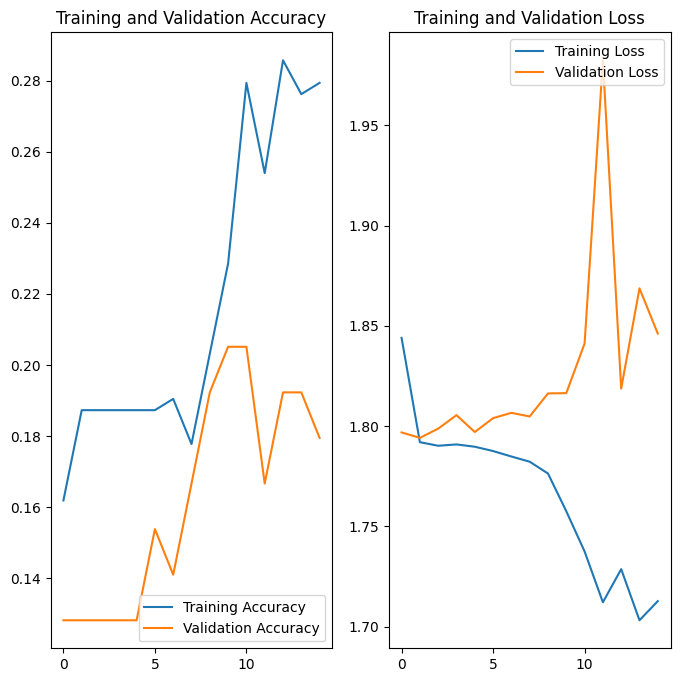

In [141]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 73ms/step
This image most likely belongs to knight with a 67.84 percent confidence.


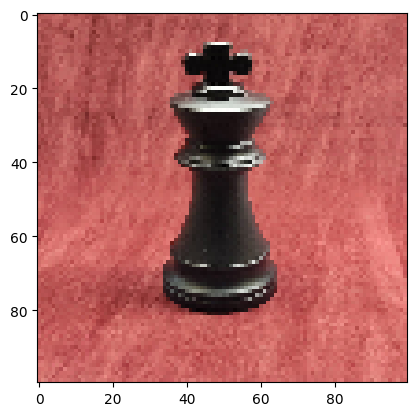

In [142]:
chess_url = "https://i.etsystatic.com/22169559/r/il/6e96e1/4708353618/il_fullxfull.4708353618_43bu.jpg"
chess_path = tf.keras.utils.get_file(origin=chess_url)

img = tf.keras.utils.load_img(
    chess_path, target_size=(img_height, img_width)
)

plt.imshow(img)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

# model.save('model.keras')


